# The transient Universe - Nested sampling

In [1]:
import numpy as np    
import scipy.stats
import pylab as plt  

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

plt.style.use('seaborn-v0_8-deep')
plt.rc('text', usetex=True)  
%matplotlib inline
%config InlineBackend.figure_format='retina'

Read the npy file

In [2]:
input_file_path = '/Users/giulia/coding/astrostat/astrostatistics_bicocca_2024/solutions/transient.npy'
data = np.load(input_file_path)

#print(data)

This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

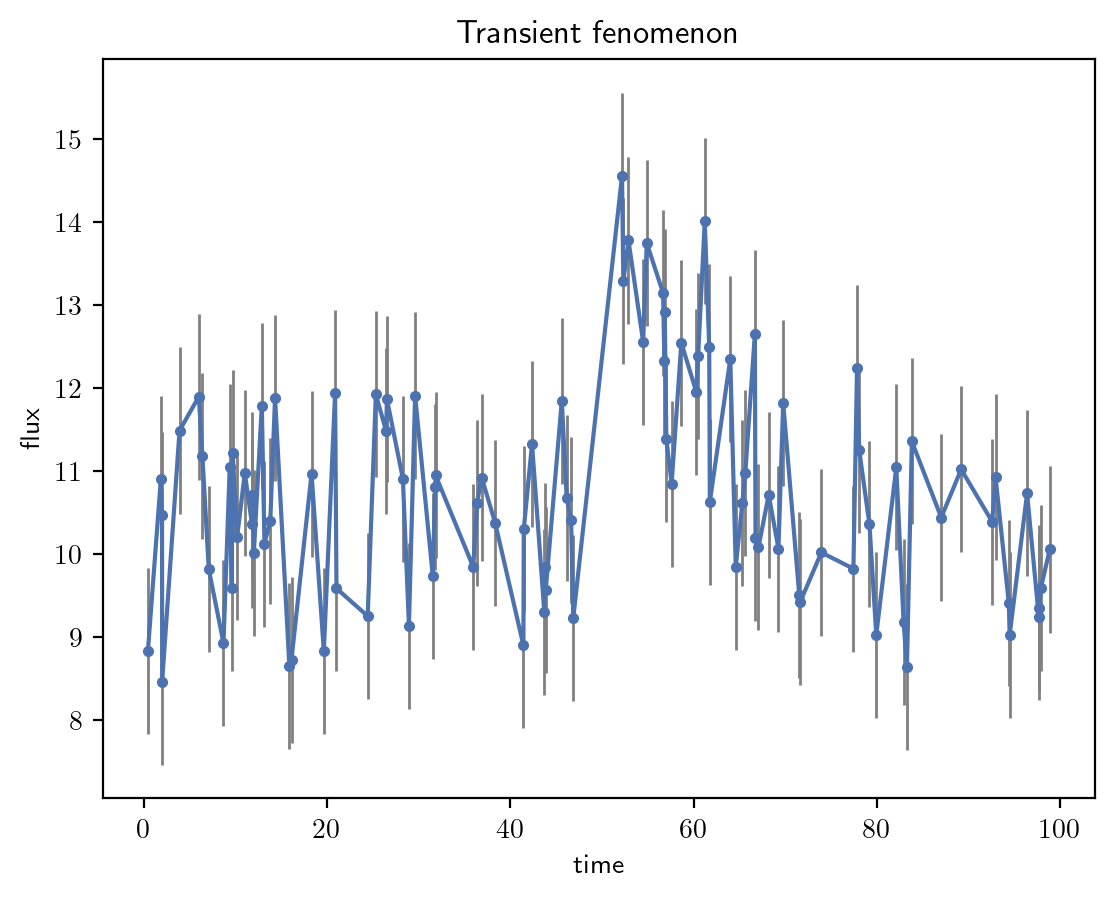

In [3]:
t,y,yerr=data.T

plt.errorbar(t,y,yerr=yerr, marker = '.', ecolor='gray', elinewidth=1)
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Transient fenomenon')

plt.show()

### I'll use Dynesty

Using the crash course: https://dynesty.readthedocs.io/en/latest/crashcourse.html

The log likelihood

In [4]:
def LogLikelihood(theta, data, model):
    x, y, sigma_y = data.T
    if model=='burst':
        y_model = burst_model(x, theta)
    if model=='gauss':
        y_model = gauss_model(x, theta)
    return -0.5 * np.sum((y-y_model)**2 / sigma_y**2 ) 

## Burst model

The model

In [5]:
def burst_model(x, theta):
    A, b, t0, alpha = theta
    result = b + A * np.exp(-alpha * (x - t0))
    result[x < t0] = b
    return result

The log prior

In [6]:
Amin, Amax = 0, 50
bmin, bmax = 0, 50
t0min, t0max = 0, 100
alphamin, alphamax = np.exp(-5), np.exp(5)

def burst_prior_transform(u):
    x = np.zeros(len(u))

    x[0] = scipy.stats.uniform(loc=Amin, scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin, scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min, scale=t0max-t0min).ppf(u[2])
    x[3] = scipy.stats.loguniform.ppf(u[3], alphamin, alphamax)
    return x

### Nested sampling (burst)

In [7]:
ndim = 4             # number of parameters in the model

sampler = dynesty.NestedSampler(LogLikelihood, burst_prior_transform, ndim, logl_args=[data, 'burst'], nlive=200)

sampler.run_nested()
burst_sresults = sampler.results

#NB: in dynesty.NestedSampler devo aggiungere a parte gli argomenti di loglike e ptransf che non siano x!


/var/folders/lx/nx_0fbmn2xxcrxcn7tmrlntm0000gn/T/ipykernel_40947/964186044.py:3: RuntimeWarning: overflow encountered in exp
  result = b + A * np.exp(-alpha * (x - t0))
/var/folders/lx/nx_0fbmn2xxcrxcn7tmrlntm0000gn/T/ipykernel_40947/964186044.py:3: RuntimeWarning: overflow encountered in multiply
  result = b + A * np.exp(-alpha * (x - t0))
729it [00:06, 38.55it/s, bound: 0 | nc: 46 | ncall: 7285 | eff(%): 10.007 | loglstar:   -inf < -172.833 <    inf | logz: -182.123 +/-  0.205 | dlogz: 101.964 >  0.209]     /var/folders/lx/nx_0fbmn2xxcrxcn7tmrlntm0000gn/T/ipykernel_40947/964186044.py:3: RuntimeWarning: overflow encountered in exp
  result = b + A * np.exp(-alpha * (x - t0))
/var/folders/lx/nx_0fbmn2xxcrxcn7tmrlntm0000gn/T/ipykernel_40947/964186044.py:3: RuntimeWarning: overflow encountered in multiply
  result = b + A * np.exp(-alpha * (x - t0))
775it [00:06, 103.83it/s, bound: 1 | nc: 11 | ncall: 7605 | eff(%): 10.191 | loglstar:   -inf < -145.264 <    inf | logz: -153.625 +/-  0.

#### Runplot (burst)

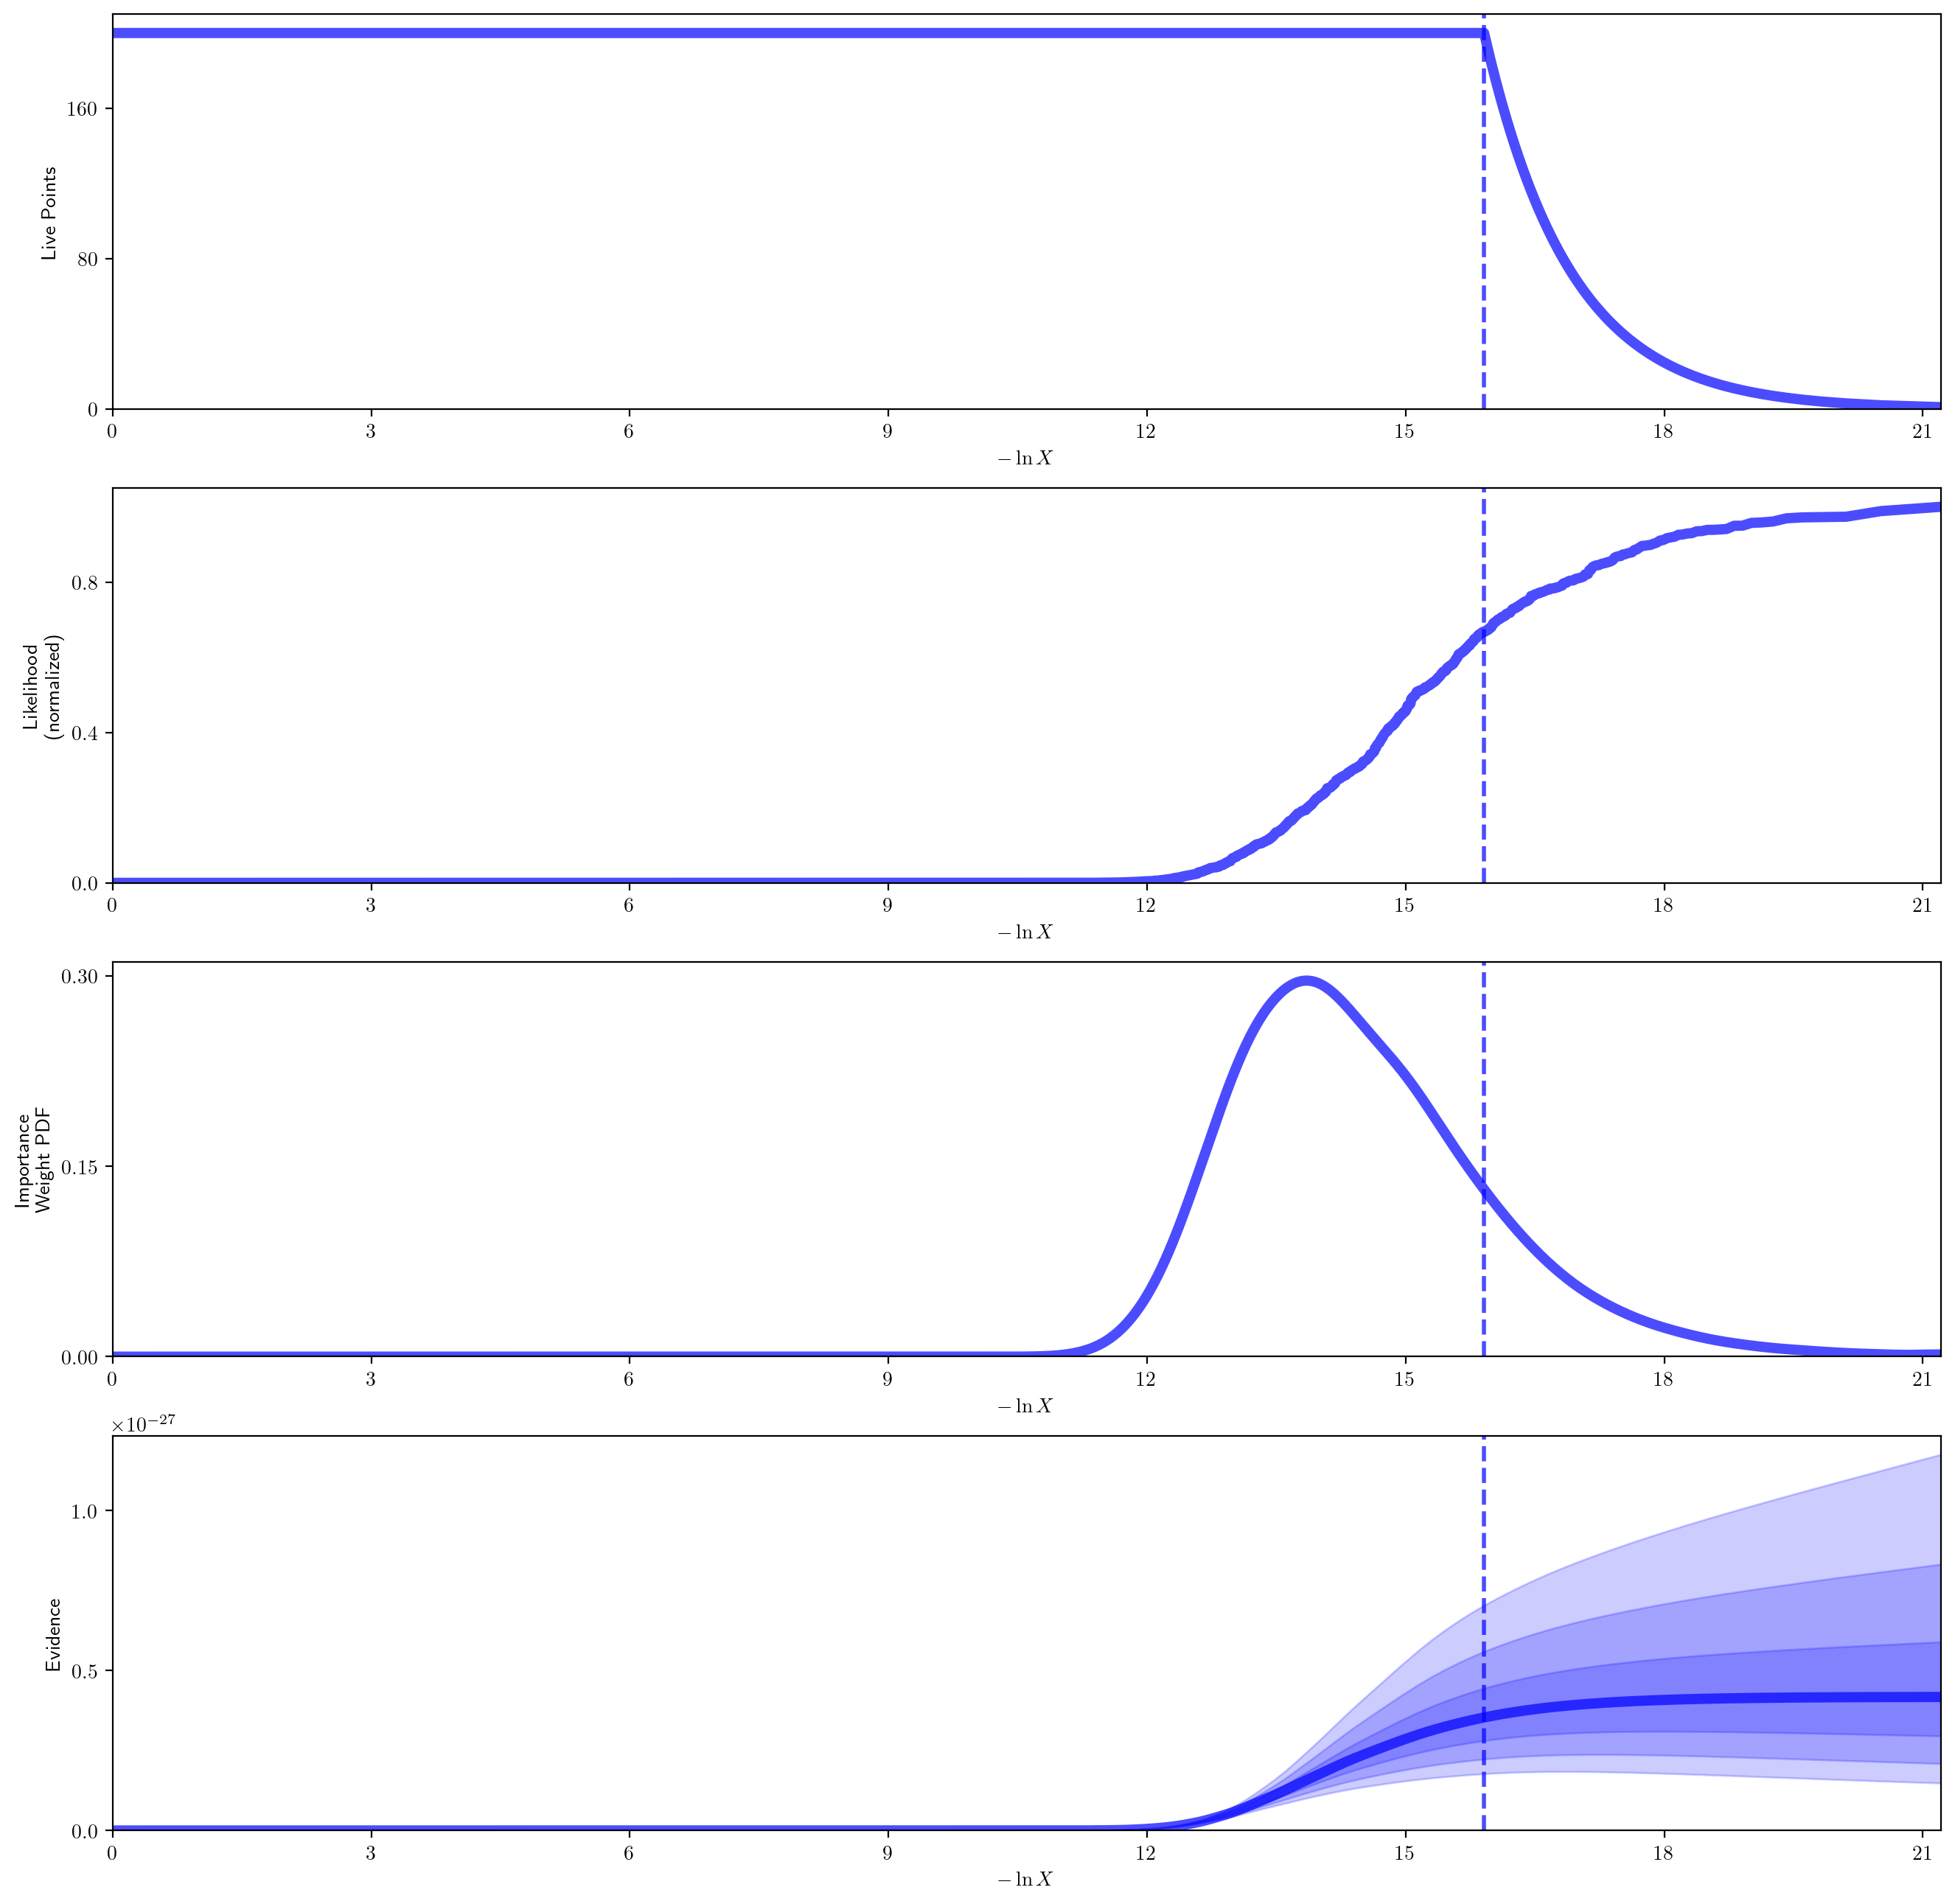

In [8]:
runplot_fig, runplot_axes = dyplot.runplot(burst_sresults)

#### Traceplots (burst)

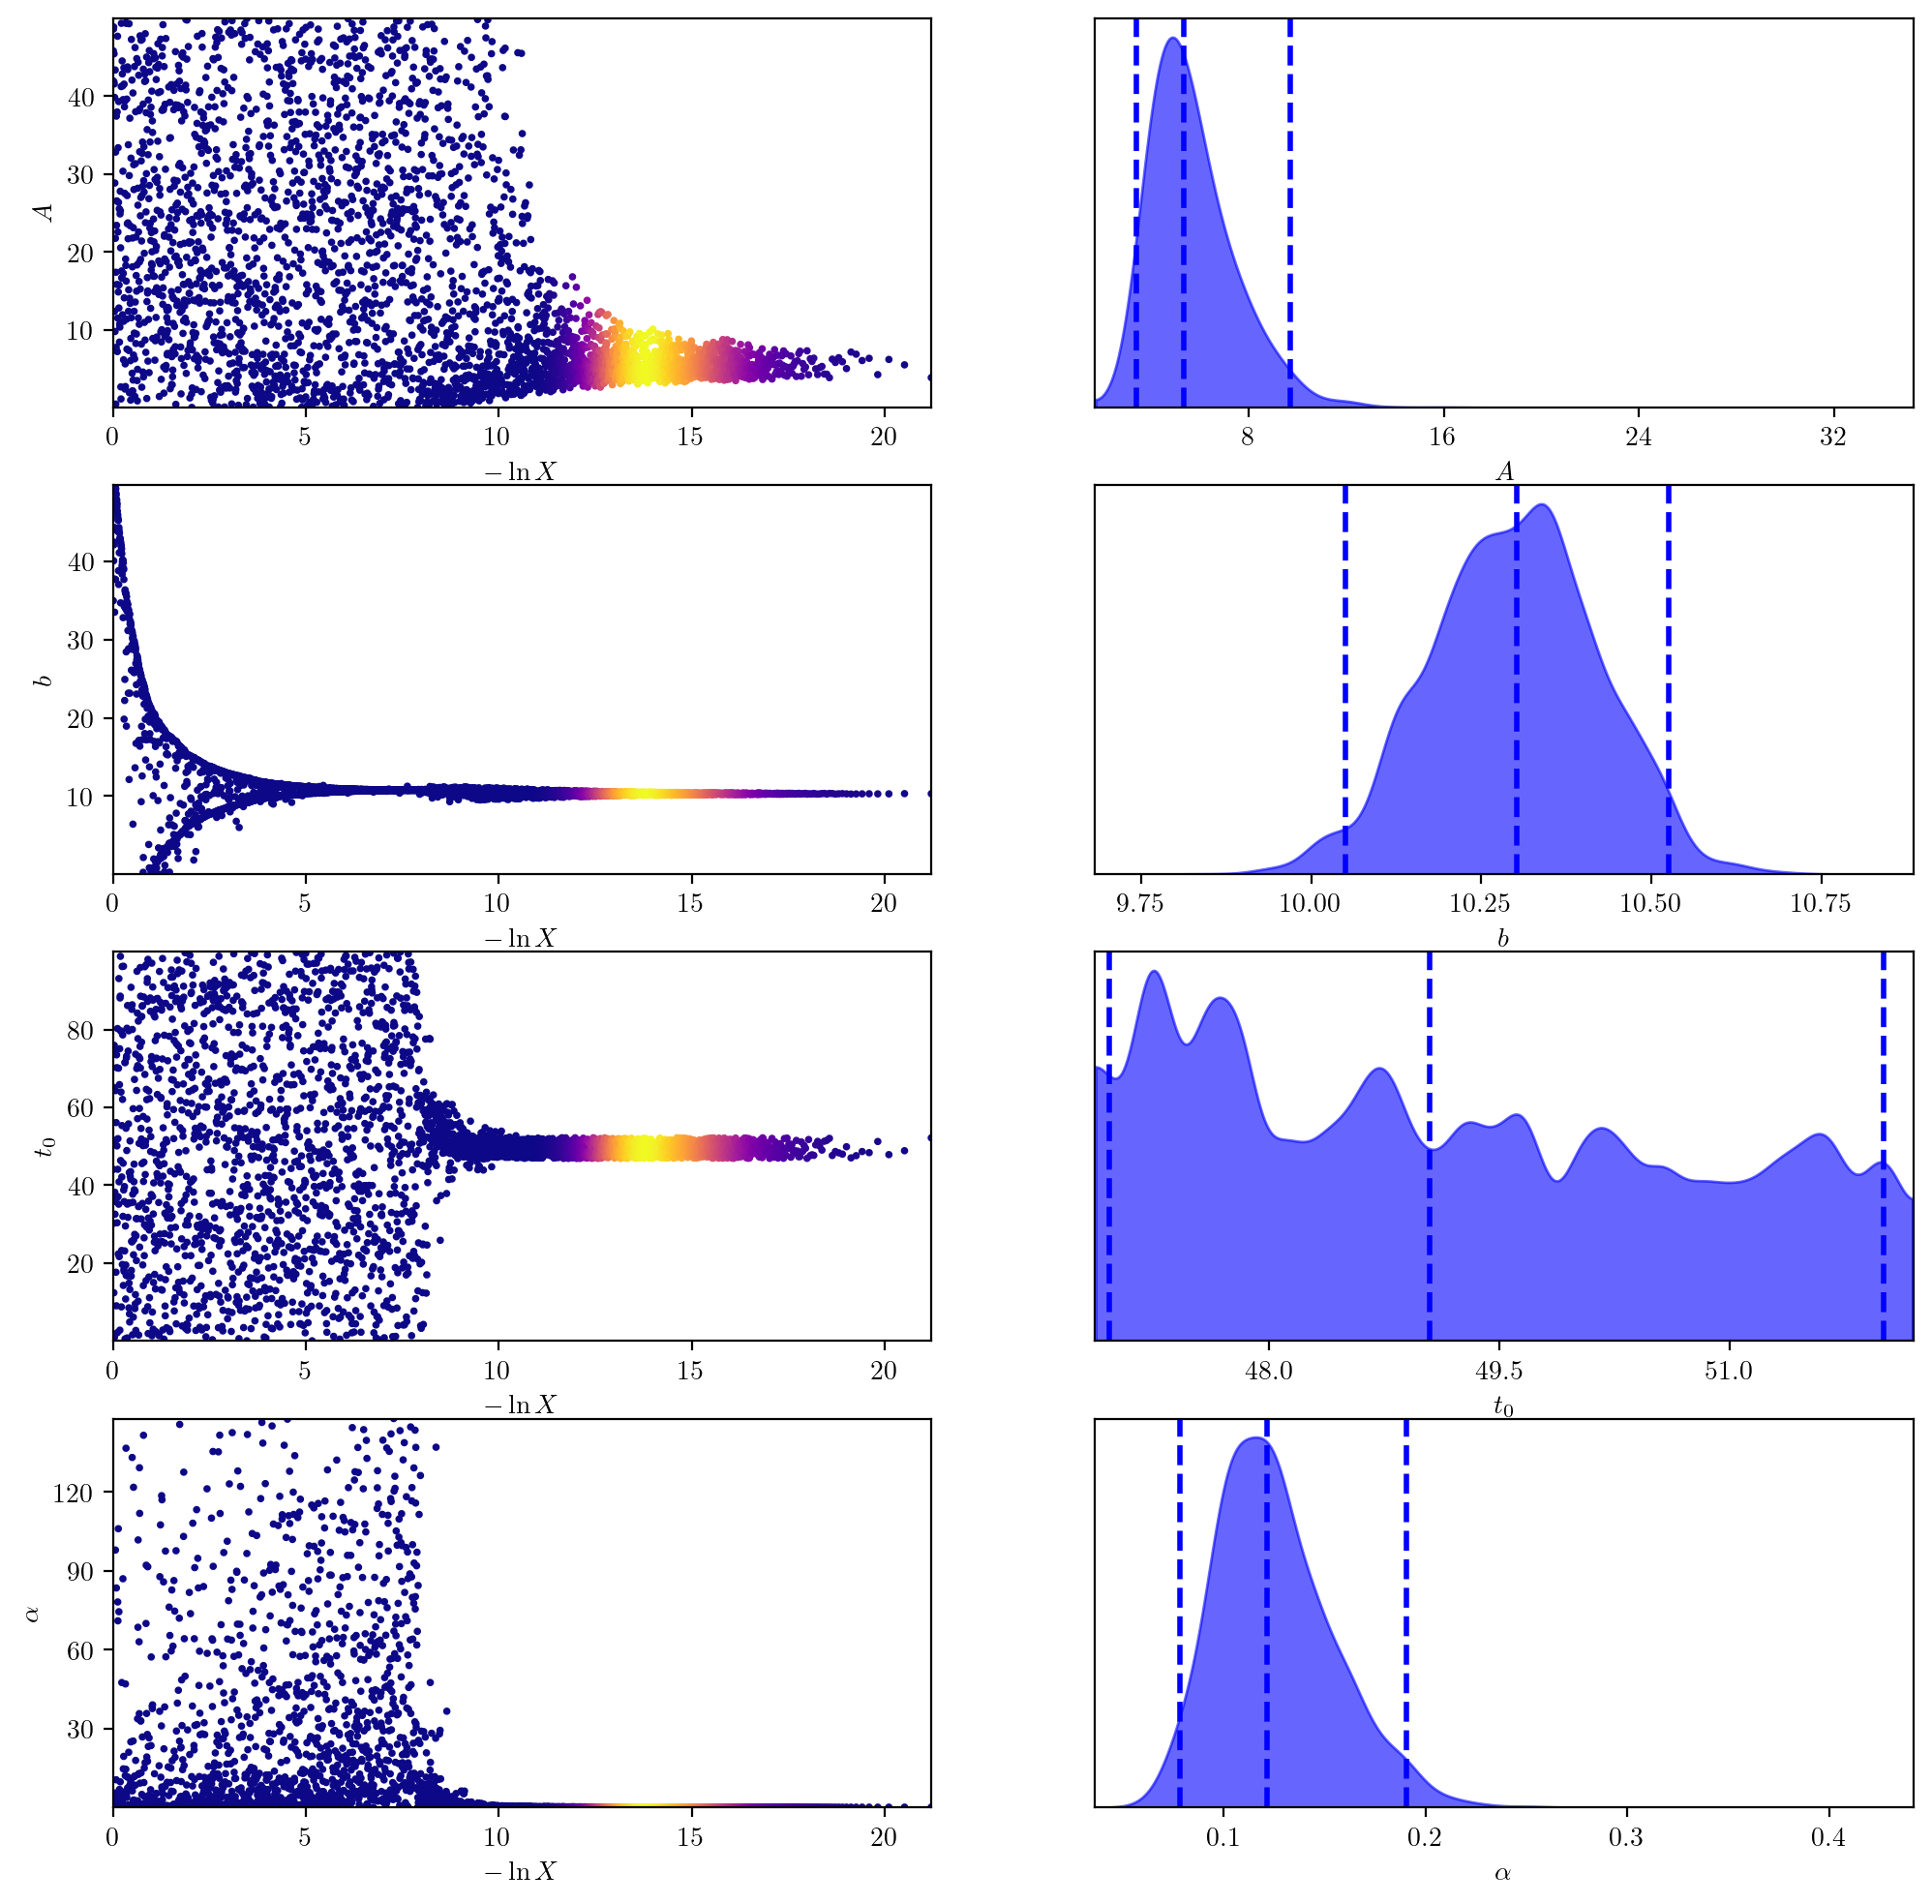

In [9]:
burst_labels = ["$A$", "$b$", "$t_0$", "$\\alpha$"]
traceplot_fig, traceplot_axes = dyplot.traceplot(burst_sresults, labels=burst_labels)

#### Corner plots (burst)

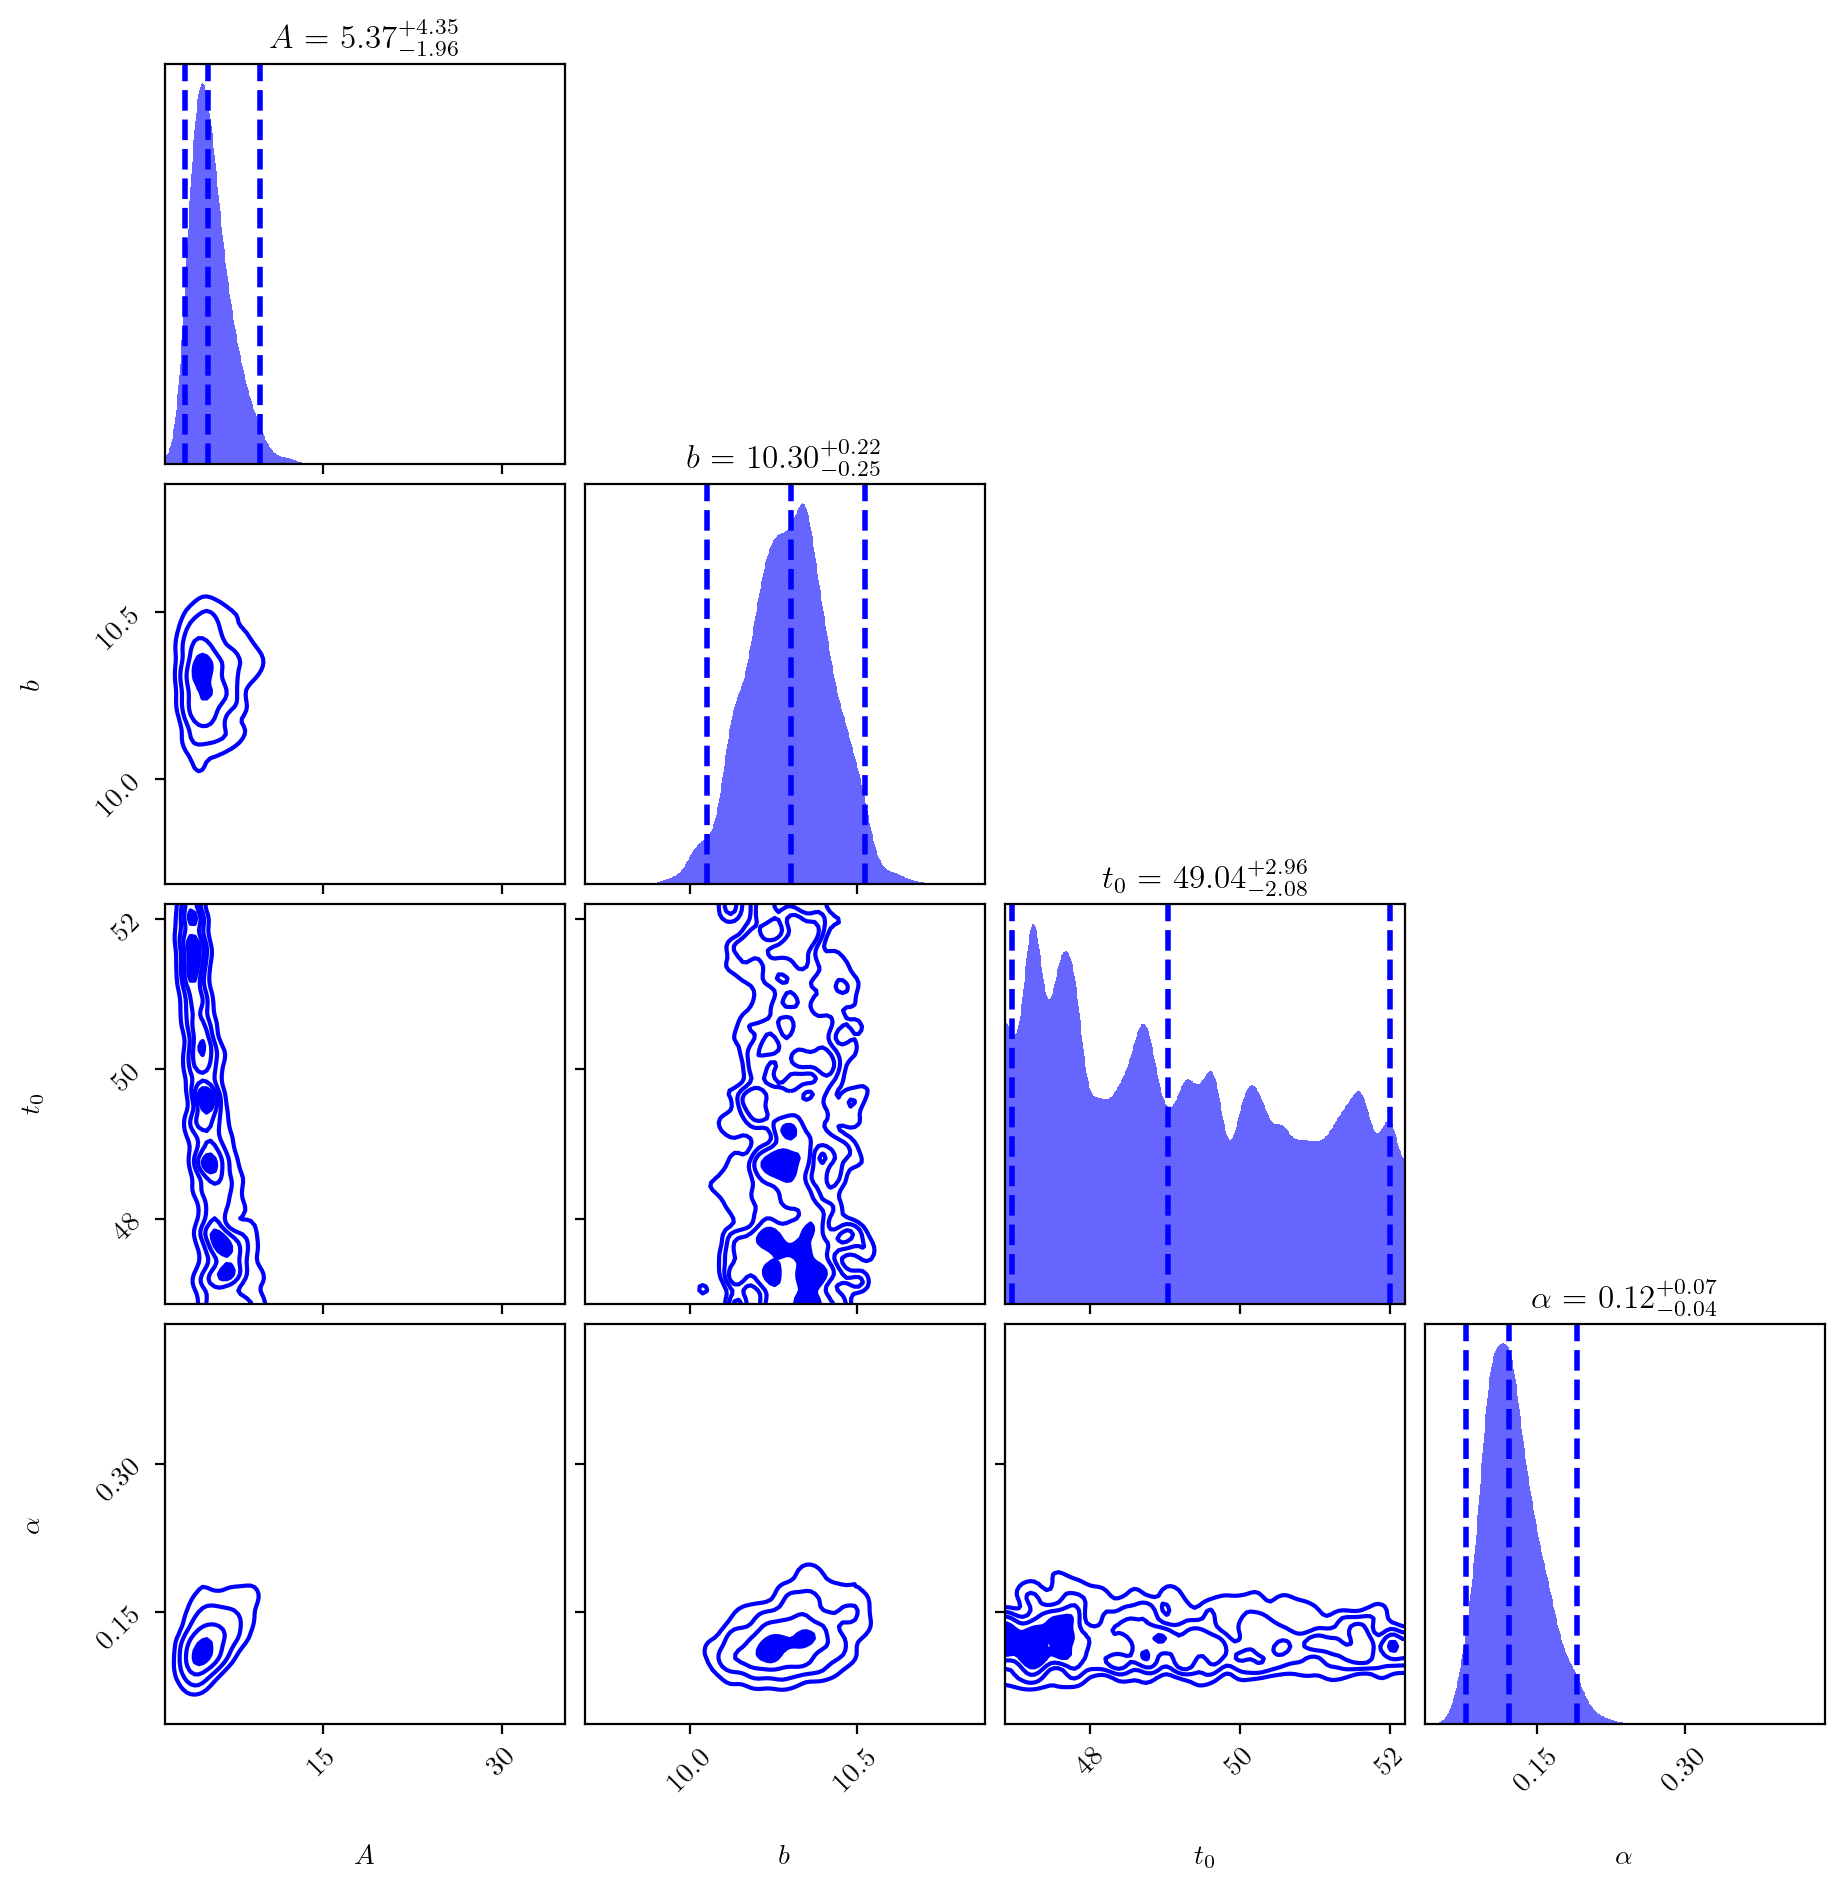

In [10]:
corner_fig, corner_axes = dyplot.cornerplot(burst_sresults, color='b', show_titles=True, max_n_ticks=3, labels=burst_labels)

#### Statistics

In [11]:
burst_samples = burst_sresults.samples  # samples
burst_weights = np.exp(burst_sresults.logwt - burst_sresults.logz[-1])  # normalized weights

Bayesian evidence for burst model

In [12]:
burst_log_evidence = burst_sresults.logz[-1]           #log-evidence
burst_log_evidence_error = burst_sresults.logzerr[-1]  #log-evidence error

#compute the evidence
burst_evidence = np.exp(burst_log_evidence)
print("Bayesian evidence for Burst:", burst_evidence)

#propagate the error 
burst_evidence_error = burst_evidence * burst_log_evidence_error
print("Bayesian evidence error for Burst:", burst_evidence_error)

Bayesian evidence for Burst: 4.172805998732658e-28
Bayesian evidence error for Burst: 1.440387038858086e-28


Median and quantiles (using the weights!)

In [13]:
percentiles = [0.05, 0.50, 0.95]
quantiles = []

for sample in burst_samples.T:
    q = dyfunc.quantile(sample, percentiles, weights=burst_weights)
    quantiles.append(q)

quantiles = np.array(quantiles)

labels = ["A","b","t0","alpha"]
for i,l in enumerate(labels):
    print(l+"   "+str(quantiles[i,0])+" +"+str(quantiles[i,1])+" -"+str(quantiles[i,2]))

A   3.6215471182777703 +5.365855870570081 -9.01667164579975
b   10.101125660329611 +10.301887906336159 -10.500257092544436
t0   47.123907661220834 +49.04485434886483 -51.863120366555464
alpha   0.08371168139777252 +0.1215282157086094 -0.18032182306688763


Mean and covariance (still using weights)

In [14]:
mean, cov = dyfunc.mean_and_cov(burst_samples, burst_weights)

print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

Mean and covariance of parameters are: [ 5.7004134  10.2980617  49.22030517  0.1253852 ]
[[ 2.84798851e+00  1.40239590e-02 -1.76760662e+00  2.85930998e-02]
 [ 1.40239590e-02  1.50528596e-02 -1.41546009e-03  1.38755036e-03]
 [-1.76760662e+00 -1.41546009e-03  2.41834502e+00 -1.71665146e-03]
 [ 2.85930998e-02  1.38755036e-03 -1.71665146e-03  8.31878347e-04]]


# Gauss

In [15]:
def gauss_model(x, theta):
    A, b, t0, sigma = theta
    result = b + A * np.exp(-(x - t0)**2/(2*sigma**2))
    return result

#### MLE estimation

In [16]:
tgrid=np.linspace(0,100,100)
A_0=5
b_0=10
t0_0=50
sigma_0=5.3

theta_0 = np.array([A_0,b_0,t0_0,sigma_0])

In [17]:
_logL = lambda par : -LogLikelihood(par, data, 'gauss')
best_params = scipy.optimize.fmin_bfgs(_logL, theta_0, disp=False)

A, b, t0, sigma = best_params
print(best_params)

[ 2.75109179 10.30690944 55.47275802  5.36990209]


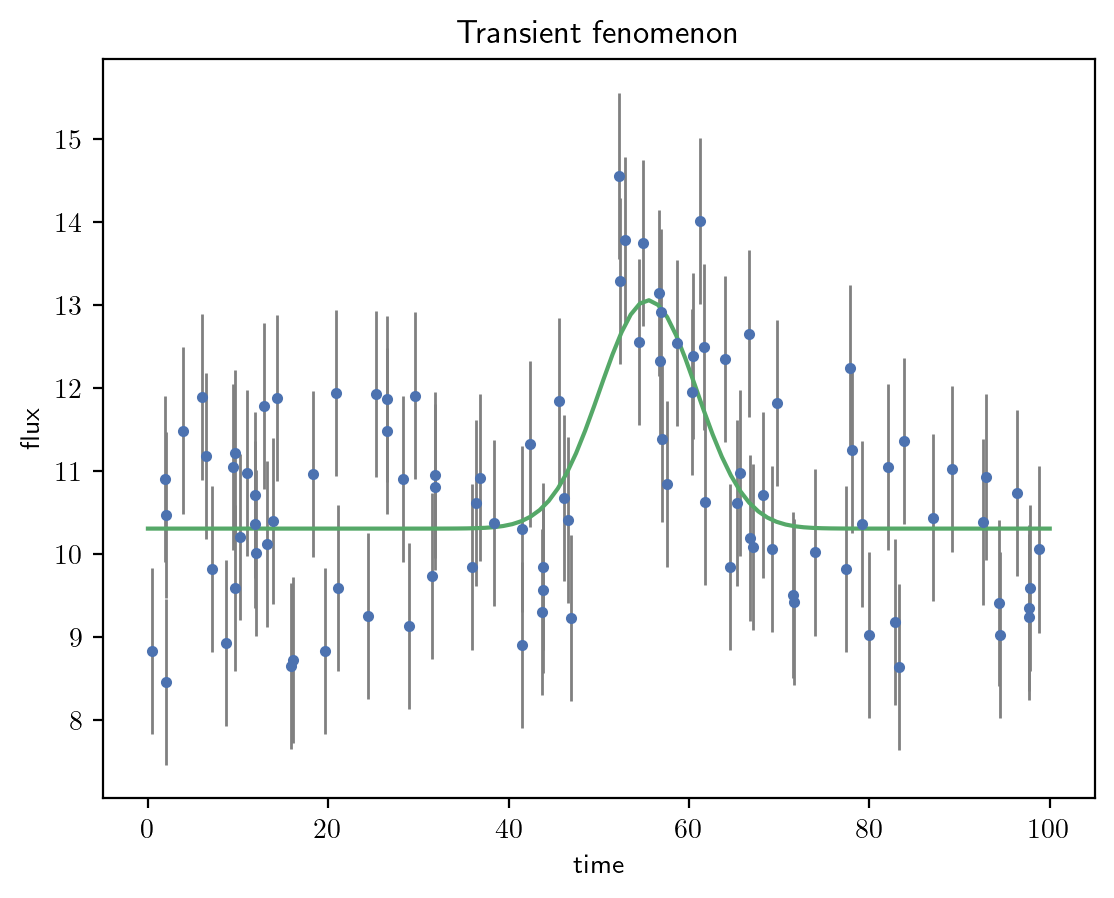

In [18]:
ygrid = gauss_model(tgrid,best_params)

plt.errorbar(t,y,yerr=yerr, fmt='.', ecolor='gray', elinewidth=1)
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Transient fenomenon')
plt.plot(tgrid,ygrid)

plt.show()

In [19]:
Amin, Amax = 0, 50
bmin, bmax = 0, 50
t0min, t0max = 0, 100
sigmamin, sigmamax = np.exp(-2), np.exp(2)

def gauss_prior_transform(u):
    x = np.zeros(len(u))

    x[0] = scipy.stats.uniform(loc=Amin, scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin, scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min, scale=t0max-t0min).ppf(u[2])
    x[3] = scipy.stats.loguniform.ppf(u[3], sigmamin, sigmamax)
    
    return x

### Nasted sampling (gauss)

In [20]:
ndim = 4             # number of parameters in the model

sampler = dynesty.NestedSampler(LogLikelihood, gauss_prior_transform, ndim, logl_args=[data, 'gauss'], nlive=200)

sampler.run_nested()
gauss_sresults = sampler.results

1591it [00:29, 10.67it/s, bound: 80 | nc: 63 | ncall: 31347 | eff(%):  5.075 | loglstar:   -inf < -86.877 <    inf | logz: -94.396 +/-  0.182 | dlogz: 30.523 >  0.209]     /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a v

#### Runplot (gauss)

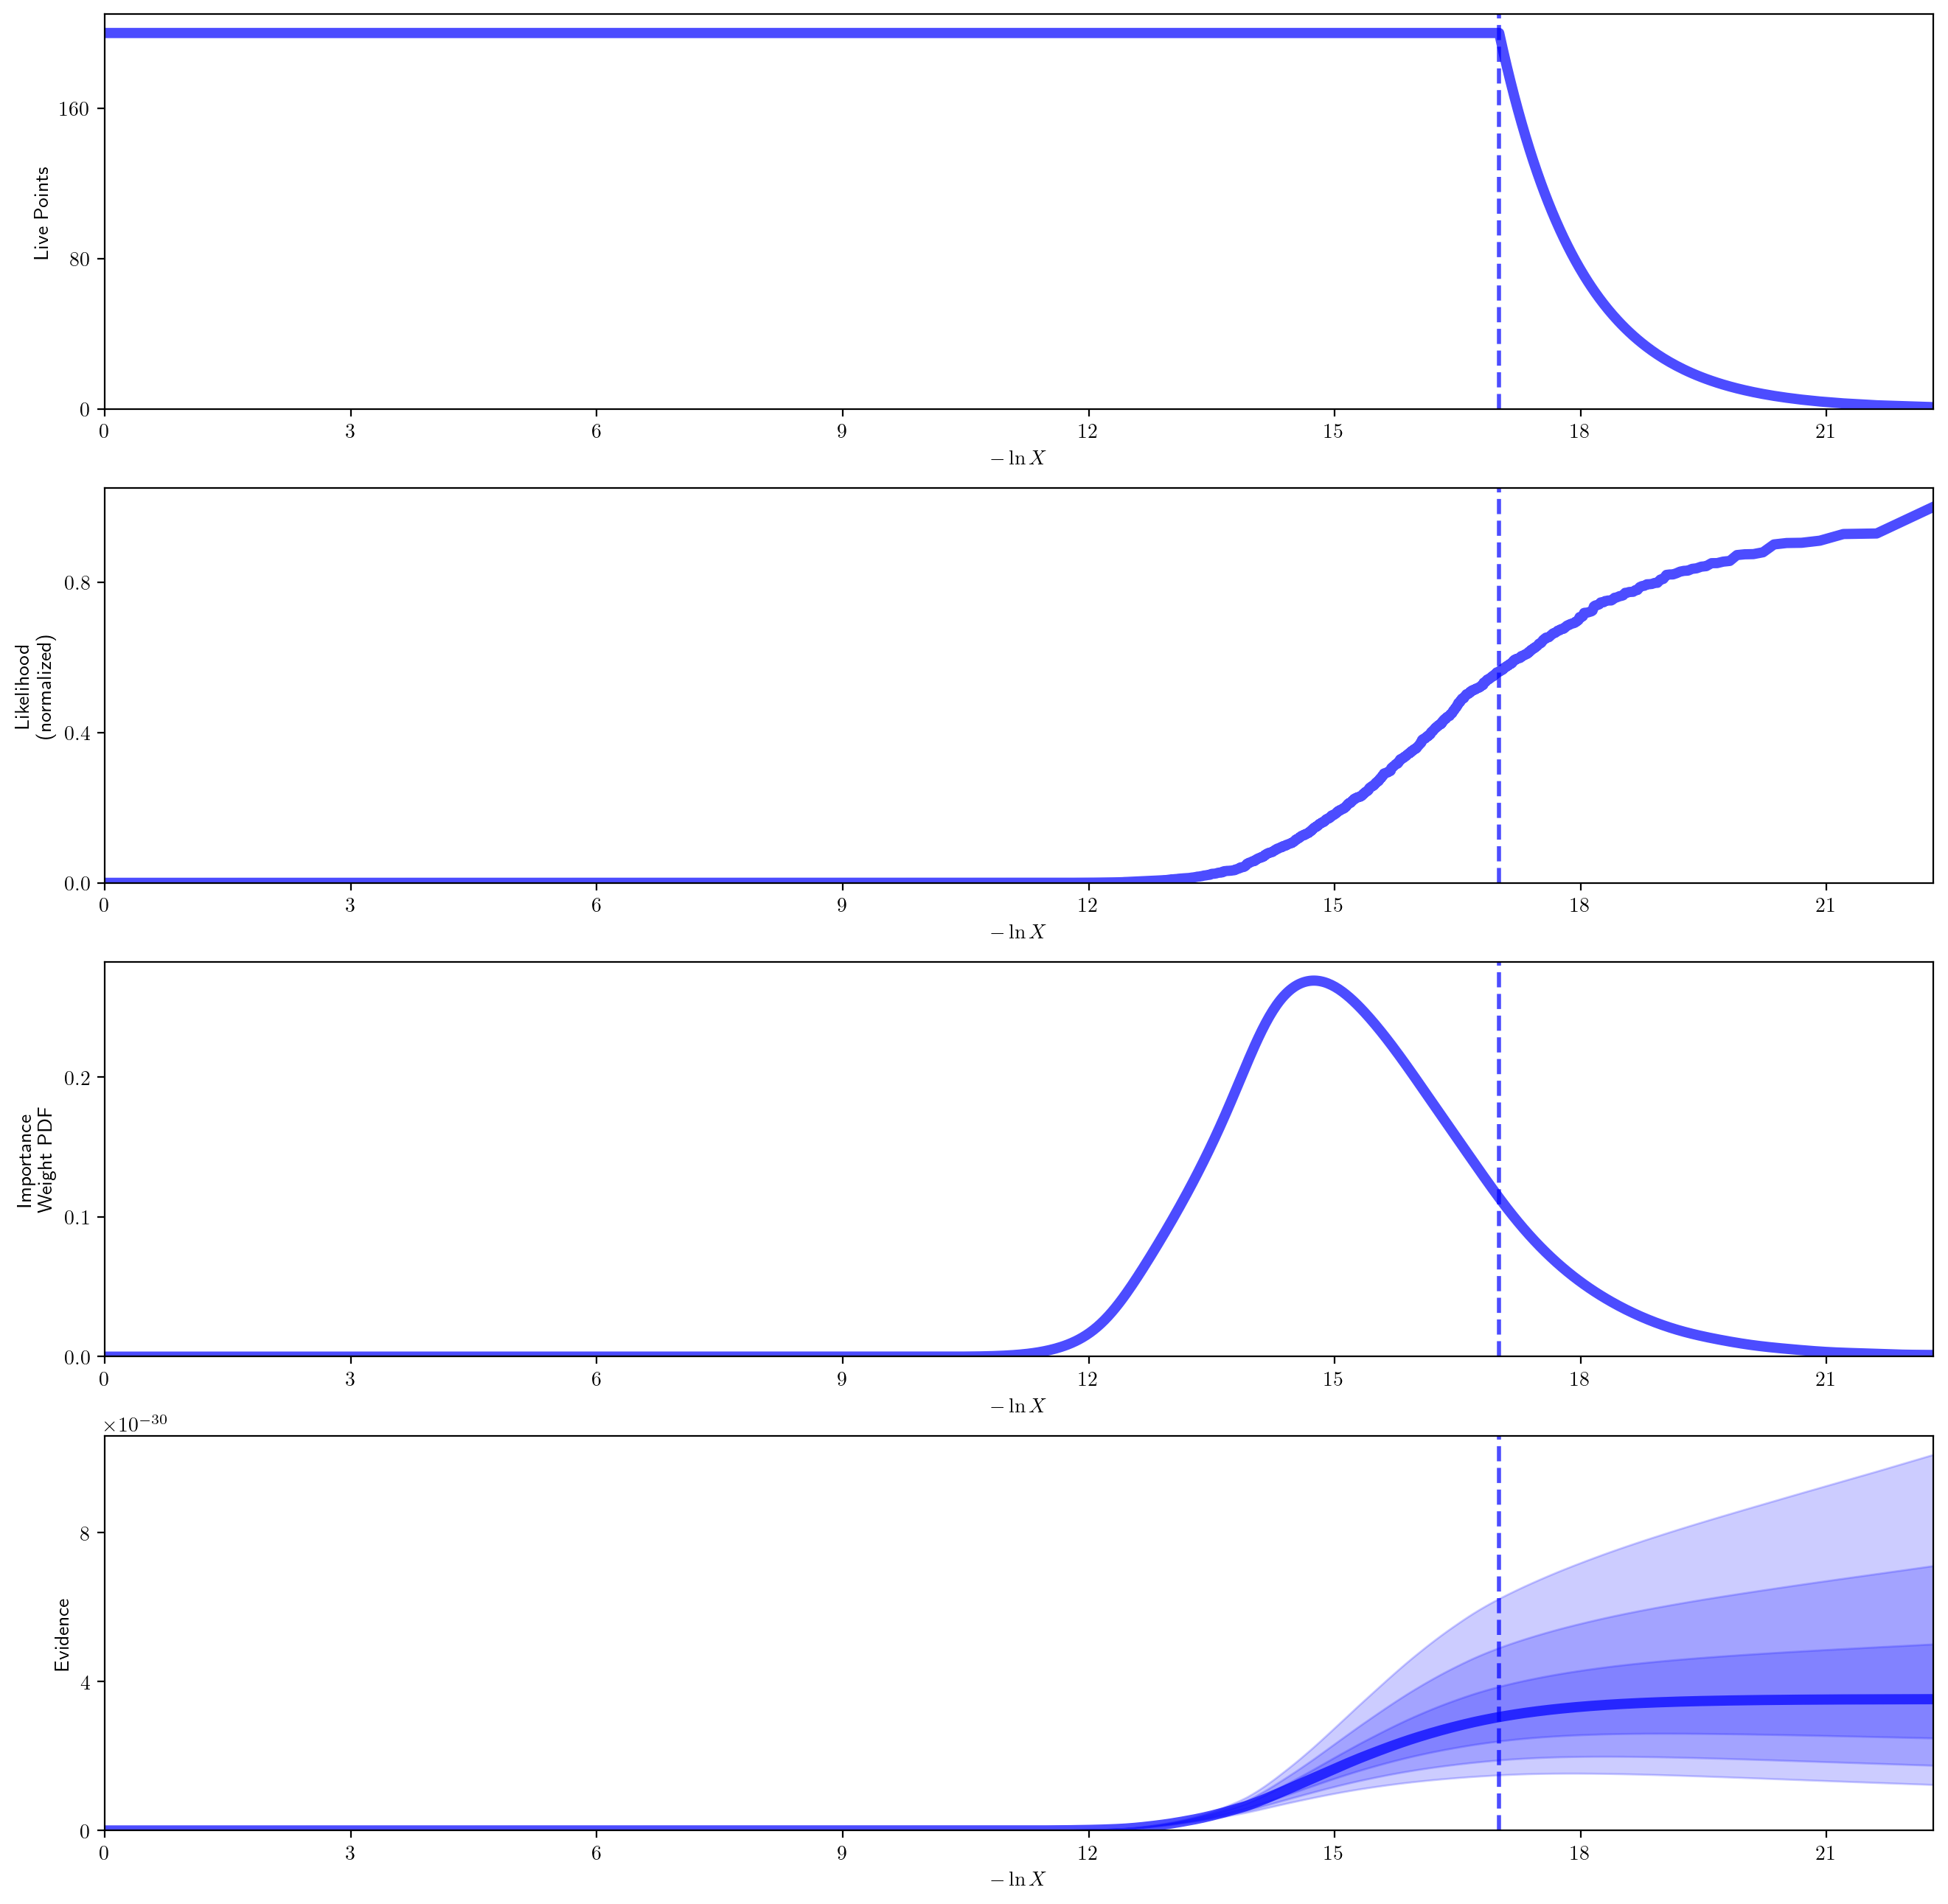

In [21]:
unplot_fig, runplot_axes = dyplot.runplot(gauss_sresults)

#### Trace plot (gauss)

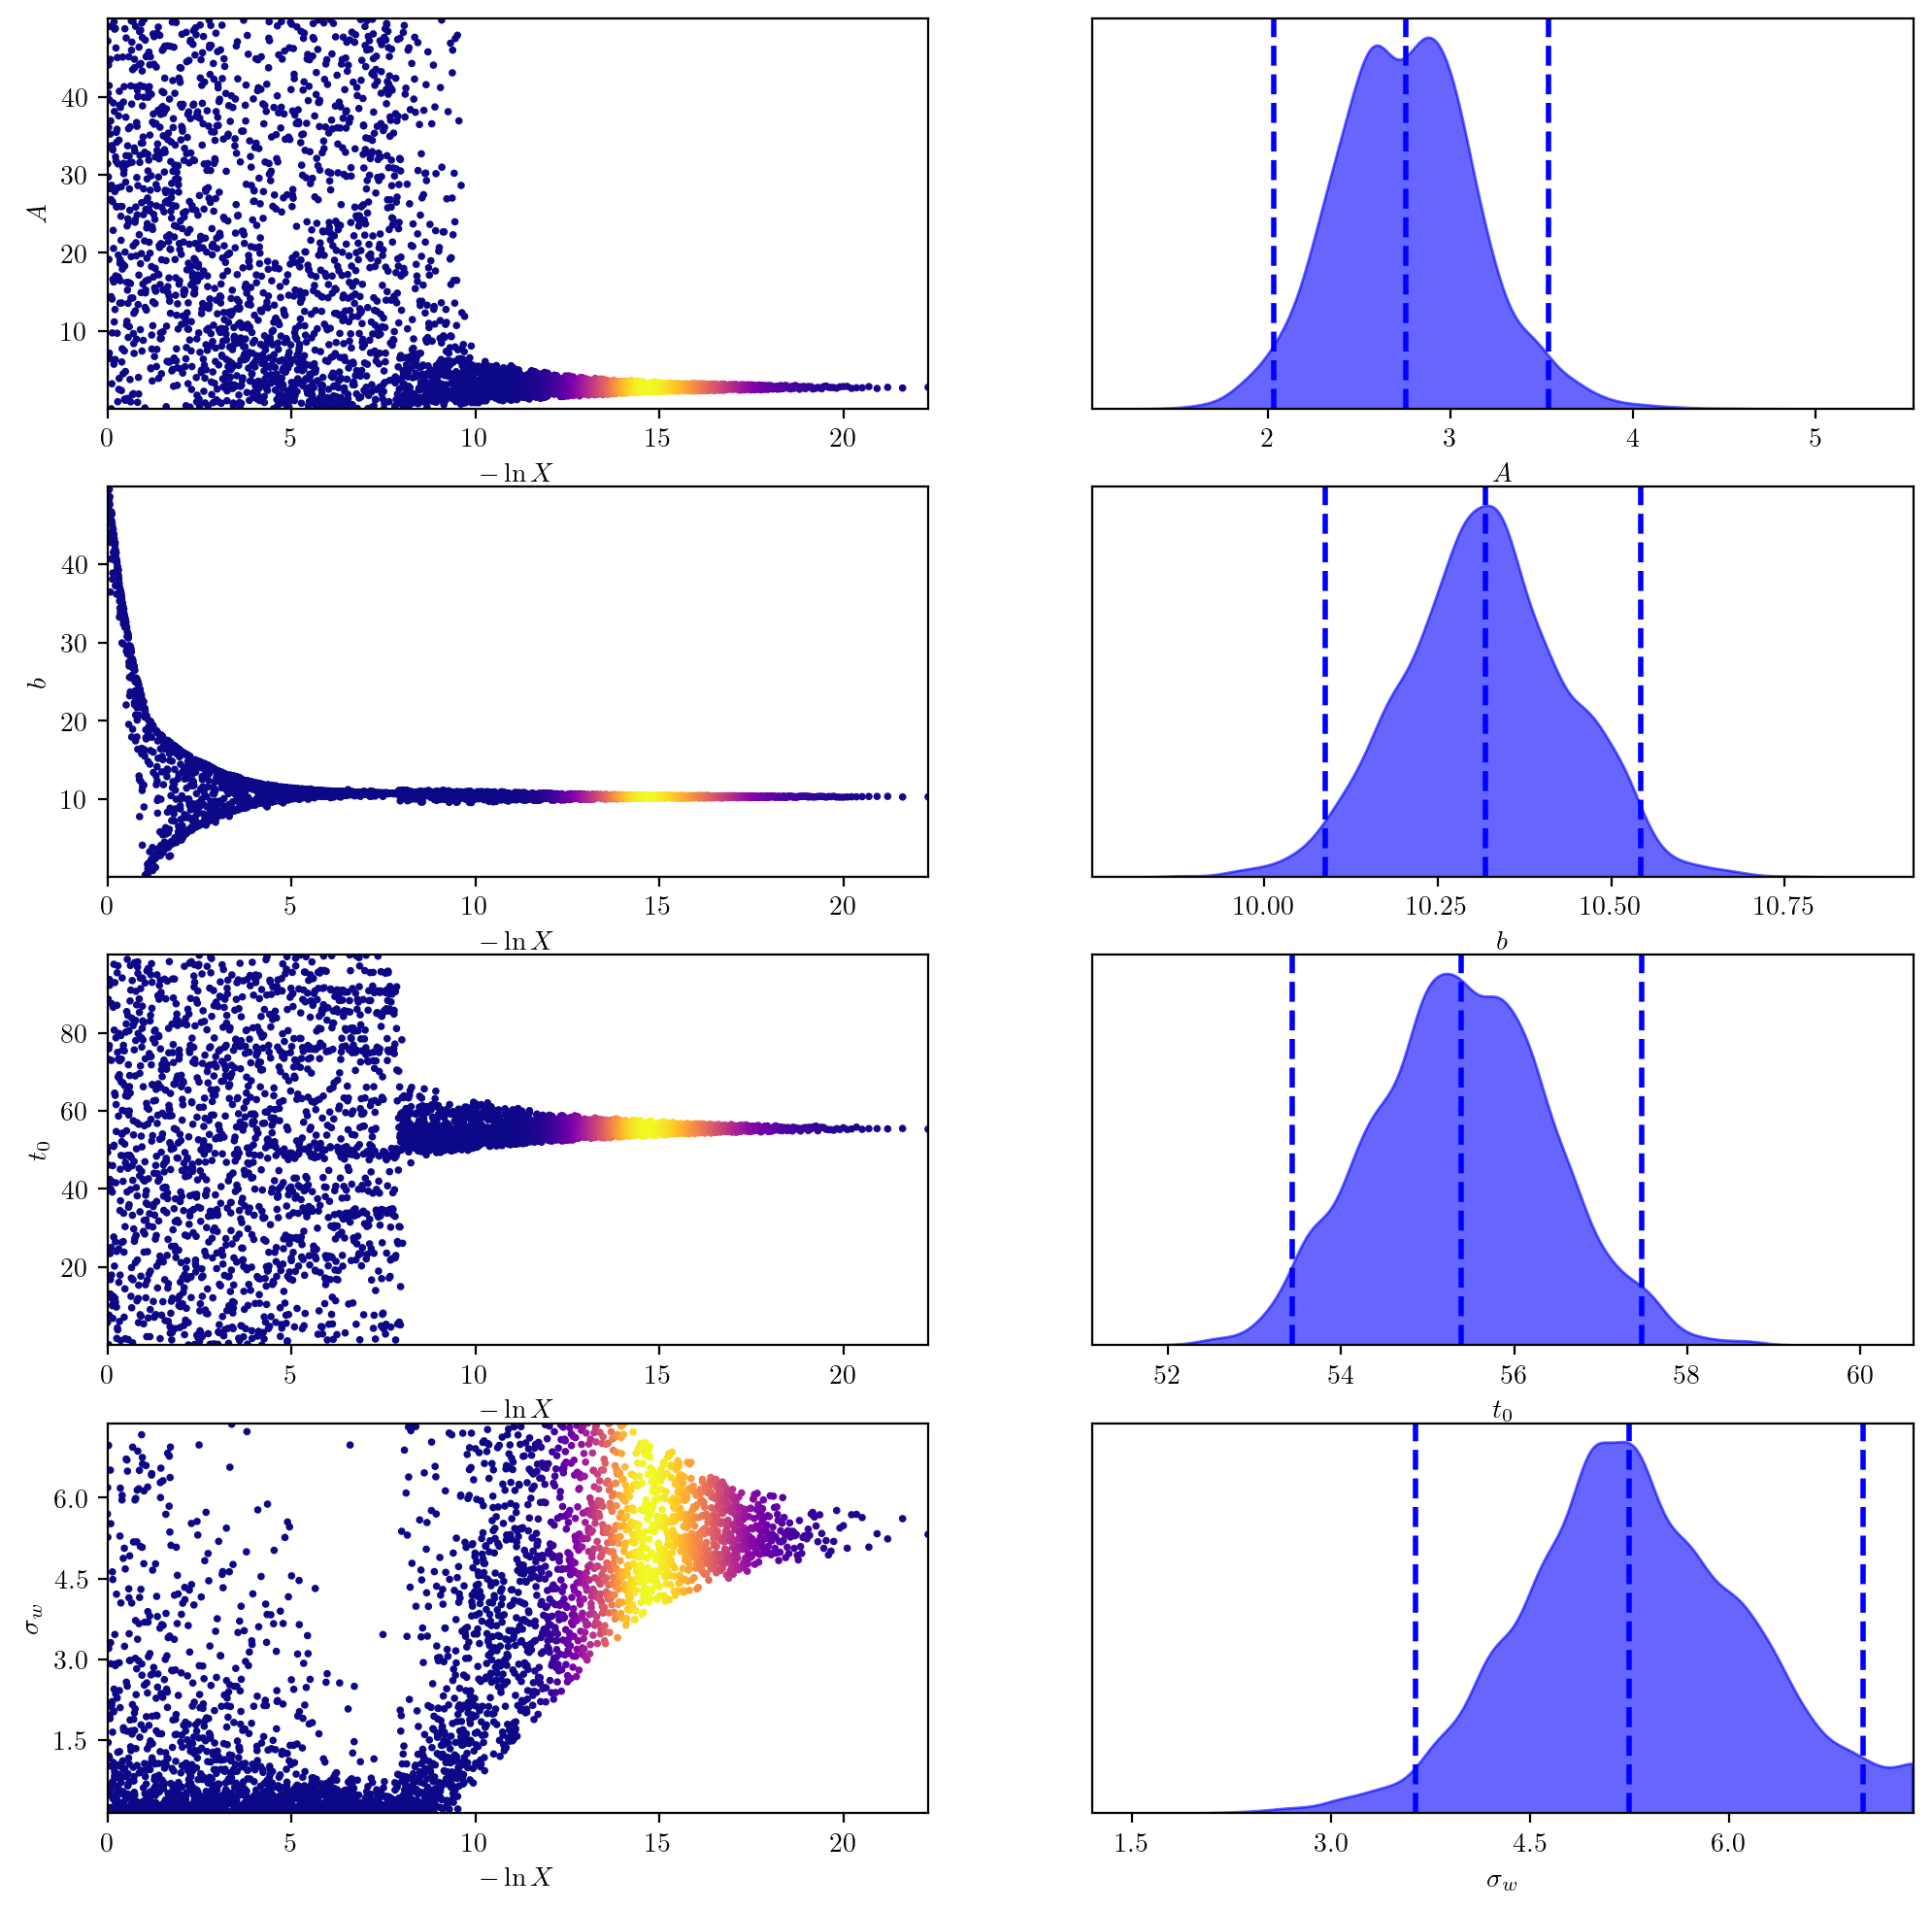

In [22]:
gauss_labels = ["$A$", "$b$", "$t_0$", "$\\sigma_w$"]
traceplot_fig, traceplot_axes = dyplot.traceplot(gauss_sresults, labels=gauss_labels)

#### Corner plot (gauss)

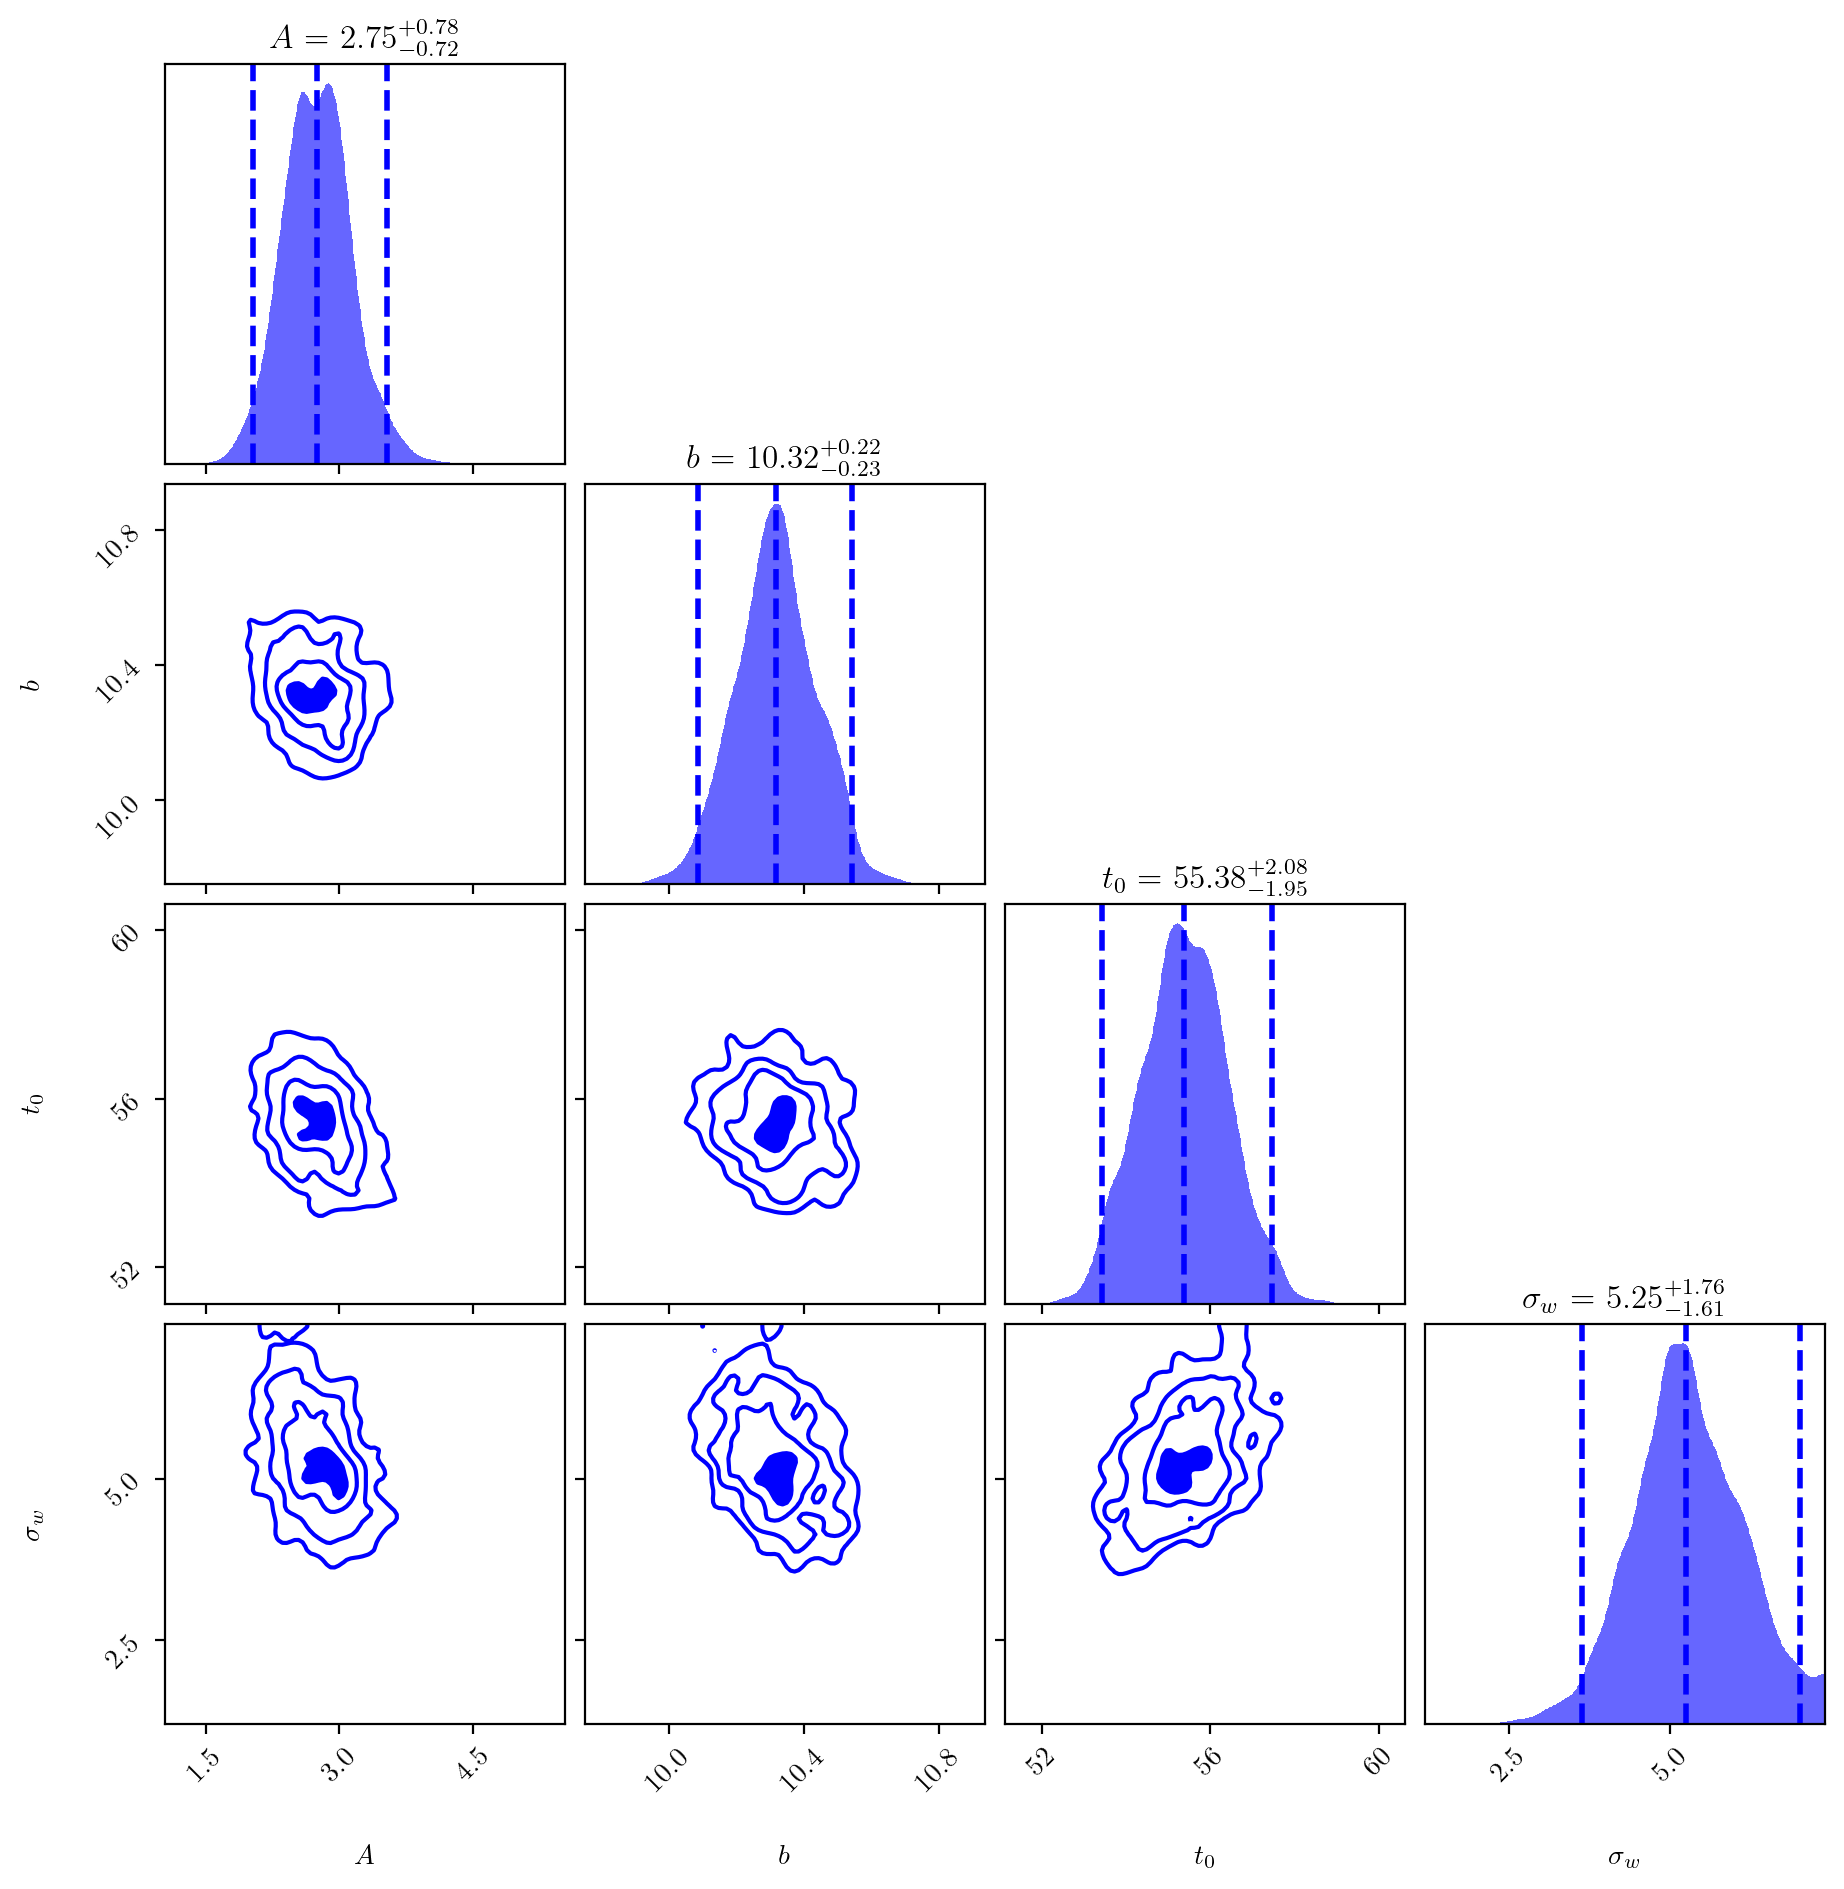

In [23]:
corner_fig, corner_axes = dyplot.cornerplot(gauss_sresults, color='b', show_titles=True, max_n_ticks=3, labels=gauss_labels)

#### Statistics (gauss)

In [24]:
gauss_log_evidence = gauss_sresults.logz[-1]          
gauss_log_evidence_error = gauss_sresults.logzerr[-1]

#compute the evidence
gauss_evidence = np.exp(gauss_log_evidence)
print("Bayesian evidence for Gauss:", gauss_evidence)

#propagate the error 
gauss_evidence_error = gauss_evidence * gauss_log_evidence_error
print("Bayesian evidence error for Gauss:", gauss_evidence_error)

Bayesian evidence for Gauss: 3.527608909465007e-30
Bayesian evidence error for Gauss: 1.2374334016817246e-30


In [25]:
gauss_samples = gauss_sresults.samples
gauss_weights = np.exp(gauss_sresults.logwt - gauss_sresults.logz[-1])

In [26]:
percentiles = [0.05, 0.50, 0.95]
gauss_quantiles = []

for sample in gauss_samples.T:
    q = dyfunc.quantile(sample, percentiles, weights=gauss_weights)
    gauss_quantiles.append(q)

gauss_quantiles = np.array(gauss_quantiles)

labels = ["A","b","t0","alpha"]
for i,l in enumerate(labels):
    print(l+"   "+str(gauss_quantiles[i,0])+" +"+str(gauss_quantiles[i,1])+" -"+str(gauss_quantiles[i,2]))

A   2.144588136120522 +2.753090444406339 -3.409132083129334
b   10.120901086682911 +10.317992714177567 -10.517968698774588
t0   53.673936175405345 +55.38301034554028 -57.07654118370643
alpha   3.907460044289624 +5.247070456350464 -6.701317960510417


In [27]:
gauss_mean, gauss_cov = dyfunc.mean_and_cov(gauss_samples, gauss_weights)

print('Mean and covariance of parameters are: ' + str(gauss_mean) + '\n' + str(gauss_cov))

Mean and covariance of parameters are: [ 2.75452227 10.31847878 55.38865968  5.27389335]
[[ 0.14781877 -0.00928813 -0.15418858 -0.14056709]
 [-0.00928813  0.0143248  -0.0228119  -0.04065942]
 [-0.15418858 -0.0228119   1.04738485  0.36895159]
 [-0.14056709 -0.04065942  0.36895159  0.71915735]]


# Compare evidences

In [28]:
bayes_factor = burst_evidence/gauss_evidence
print('Bayes factor: ' + str(bayes_factor))

# propagate the error
bayes_factor_error = bayes_factor * np.sqrt((burst_evidence_error/burst_evidence)**2 + (gauss_evidence_error/gauss_evidence)**2)
print('Bayes factor error: ' + str(bayes_factor_error))

Bayes factor: 118.28992685488767
Bayes factor error: 58.2152941811069


In [29]:
def bayes_factor_to_jeffreys(bf):
    if bf < 1:
        return "Negative"
    elif 1 <= bf < 3:
        return "Barely worth mentioning"
    elif 3 <= bf < 10:
        return "Substantial"
    elif 10 <= bf < 30:
        return "Strong"
    elif 30 <= bf < 100:
        return "Very strong"
    elif bf >= 100:
        return "Decisive"

In [30]:
print('Jeffrey scale (for Burst/Gauss): ' + bayes_factor_to_jeffreys(bayes_factor))

Jeffrey scale (for Burst/Gauss): Decisive
